<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Data Wrangling</h1><h2>Assignment 1 </h2><h3>Specialist Diploma in Data Analytics</h3></th>
    </tr>
</table>

### marker: Joey Chew <br> grade: A

In [1]:
#JC

# good face-to-face presentation with slides also showing simultaneously

# good work, wrangling steps were not unnecessarily complicated, and results generated, quite good

# some concerns over your choice of automatic OrdinalEncoding, please see comments in individual code cells for
# those steps

# careful about fitting on test dataset


Goh Min Ling



### Introduction: Problem Understanding
The aim is to predict the sales of each product at a particular outlet. Using this, supermarket management team will try to understand the properties of products and outlets which play a key role in increasing sales.


From the data question above, we will build a linear regression model with Item_Outlet_Sales as the y variable ( dependent variable) and other x variables (independent variable) consisting of data from other columns. Therefore, when new data comes in or if we get a data request for a particular product, we will be able to input the data and predict the sales for it. We would also be able to predict the performance of different products at different outlets if our model manages to be accurate enough.

I will also consider dropping and removing columns that may not be relevant to sales. However, two columns "Item Identifier" and "Outlet Identifier" cannot be dropped because they are directly related to the data question of predicting sales in each product and outlet, so these two variables must be in our regression model.

In [2]:
# import the pacakges
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import feature_engine.imputation as mdi

from feature_engine.encoding import OneHotEncoder, MeanEncoder, OrdinalEncoder
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import RareLabelEncoder

from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import PowerTransformer


import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

### Step 1: Load Data into Jupyter Notebook

In [3]:
data = pd.read_csv('supermarket.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Step 2: Data Preprocessing

### Step 2.1 Exploring data and Identifiying columns with null values

First we will look for the numerical variables and find the percentage of null values. We will also do the same for the categorical variables. This is to determine which columns would we need to impute values or consider dropping.As seen below, Outlet Size has quite a lot of missing values. As it may possibly be an important variable, we will be imputing values into the blanks, and will filter out at the end if it is not important to our linear regression model. We can drop the columns later if we feel that the data is not necessary to our linear regression model or not statistically significant.

In [5]:
# find numerical variables. this shows percentage of null. we see from below that Item Weight has a significant percentage.
num_cols = [c for c in data.columns if data[c].dtypes !='O']
data[num_cols].isnull().mean().sort_values()

Item_Visibility              0.000000
Item_MRP                     0.000000
Outlet_Establishment_Year    0.000000
Item_Outlet_Sales            0.000000
Item_Weight                  0.171653
dtype: float64

In [6]:
data[num_cols].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [7]:
cat_cols = [c for c in data.columns if data[c].dtypes =='O']
data[cat_cols].isnull().mean().sort_values()

Item_Identifier         0.000000
Item_Fat_Content        0.000000
Item_Type               0.000000
Outlet_Identifier       0.000000
Outlet_Location_Type    0.000000
Outlet_Type             0.000000
Outlet_Size             0.282764
dtype: float64

In [8]:
data[cat_cols].describe()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


From above, we can see that Item_Identifier has many unique categories. This may present many challenges in encoding as it would use up alot of memory in categorical encoding e.g. One Hot Encoding. Some of the categories also may not be statistically significant and would further complicate our machine learning model.

Next we need to do some data cleaning to ensure that the data makes sense.


### Step 2.2 Replacing incorrect values 

From the visualization of Item_Fat_Content in TIBCO spotfire, we have already seen that "Low Fat" and "lf" and "low fat" all belong to the same category but are classified as different categories in the visualisation due to irregular data entry. Same applies for "Regular" and "reg". Therefore we need to combine all the categories using the df. replace function in order for the data to have only two categories. We will then use the value_counts function to check if the values have been properly replaced in the data.

In [9]:
data["Item_Fat_Content"].replace({"LF": "Low Fat", "low fat": "Low Fat","reg": "Regular"}, inplace=True)

In [10]:
data["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Step 2.3 Trimming Outlier values

We will visualize the data below to identify from the histograms and box plot if any variables seem to have any outlier values.

None of the numerical variables below are of a normal distribution. Hence, we will be using transformations to obtain a more normal distribution so it can better serve our linear model. Also we need to consider that Outlet Year may not be a true numerical variable as it is a date, so it may be more similar to a categorical variable though it is a number. We will consider dropping this column later on while building the model as prima facie it does not seem to be significant in prediction of Outlet Sales. Also it may not be of interest to the company as the Outlet Establishment Year is not something that the company is able to change to improve sales, unlike Item Visibility and Item MRP which the company can adjust to fit consumer needs.

From the histogram constructed below, it seems like Item_Visibility may be suitable for outlier trimming.A very small proportion of Item Visibility beyond 0.2, hence it appears prima facie to be appropriate to be explore outlier trimming as we would not need to delete a huge amount of data if rows need to be removed, and such data seems to be a deviation from the normal distribution. We will explore this further with boxplot and trimming the data using IQR.

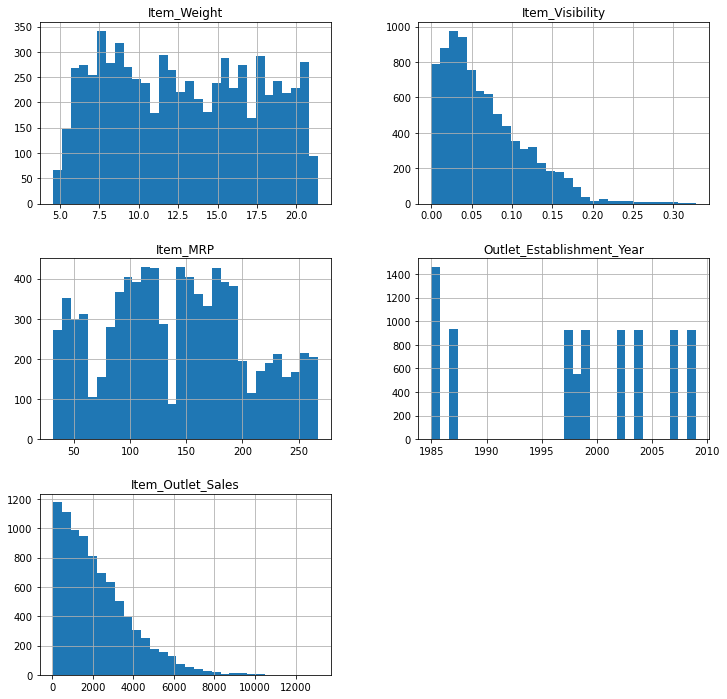

In [11]:
data[num_cols].hist(bins=30, figsize=(12,12))
plt.show()
# item outlet sales will be the target variable.

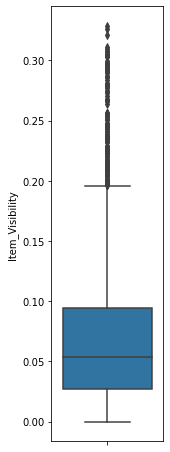

In [12]:
plt.figure(figsize=(2, 8))
sns.boxplot(y=data['Item_Visibility'])
plt.show()

In [13]:
def find_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary


RM_upper_limit, RM_lower_limit = find_boundaries(data, 'Item_Visibility', 1.5)
RM_upper_limit, RM_lower_limit

(0.195979015, -0.07440424500000001)

The Lower limit does not matter as it does not make sense that the price is less than 0. Hence we will disregard the latter result and cap the results on the lower limit.Item Visibility with Outliers Removed shows a range of Data only within 0 and 0.2 approximately which greatly reduces the number of outliers as seen in the visualisation below.


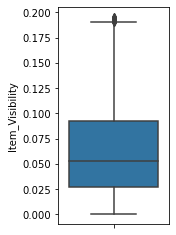

In [14]:
outliers_IV = np.where(data['Item_Visibility'] > RM_upper_limit, True,False)
data_trimmed = data.loc[~outliers_IV]
plt.figure(figsize=(2, 4))
sns.boxplot(y=data_trimmed['Item_Visibility'])
plt.show()

From the trimmed data below, we can see that 144  values are removed, compared to the 8523 rows that we had before, now it is 8379 rows.This as there values constitute a fairly small amount of the (1.7%) and we are only removing rows for this variable, we will trim the data.

In [15]:
data_trimmed.isnull().mean().sort_values()

Item_Identifier              0.000000
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Outlet_Sales            0.000000
Item_Weight                  0.165414
Outlet_Size                  0.279628
dtype: float64

In [16]:
data_trimmed

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


### Step 3: Train and Test Split

We will seperate into training and testing set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data_trimmed.drop('Item_Outlet_Sales', axis=1), data_trimmed['Item_Outlet_Sales'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((5865, 11), (2514, 11))

### Step 4: Missing Value Imputation

First we determine which columns have missing values.From below, it seems like only Item Weight and Outlet Size have missing values. Item weight is a numerical variable while Outlet Size is a categorical variable. We will input the median item weight for the numerical variable and we will use missing for the categorical variable. This is because for the categorical variable there are quite a lot of missing (28 %) and only three categories (small, medium and large), if we use most frequent to impute the data it might skew the data unfairly. 

With Item_Weight, I attempted to impute median values into the data initially, but there was a huge peak in data in the median value which unfairly skews the data. Upon further exploration of supermarket.csv, i discovered that all the missing values for Item_Weight could be attributed to 2 outlets, OUT019 and OUT027. This means that since the missing values are not random, I can't use median value as it would unfairly skew the data. A more appropriate data imputation would be arbitrary values as it would more accurately flag that fact that the values are missing.

For Outlet Size, we chose to missing value imputation. There are only three categories and 28% missing values which is quite high, so if we fill in the most frequent category into the missing value it could skew the distribution unfairly. Imputing Missing values would clearly indicate that the values were missing.

For Item Visibility, it is noted that there are 526 zero values within the column, as visualized by the histogram above and in TIBCO spotfire. It is possible that this is due to missing data, but we do not have enough evidence to conclusively determine this. The zero values contribute to only about 6% of the data and may due to the products taking up negligible shop space or other factors that we are not aware of. Therefore we will not proceed with imputation and assume that the zero values are part of the distribution.

In [18]:
X_train.isnull().mean().sort_values()

Item_Identifier              0.000000
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Weight                  0.166070
Outlet_Size                  0.283717
dtype: float64

In [19]:
features_num_arbitrary = ['Item_Weight']

features_cat_missing = ['Outlet_Size']

pipe = Pipeline(steps=[
    ('imp_num_arbitrary', mdi.ArbitraryNumberImputer(variables = features_num_arbitrary,arbitrary_number=20)),
    ('imp_cat_missing', mdi.CategoricalImputer(variables=features_cat_missing, imputation_method='missing'))
])

pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Next, we will check the number of null values to ensure that the all the values have been filled in. Since all our zero our imputation was successful and we are able to continue transforming the data.

In [20]:
X_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [21]:
X_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

### Step 5: Categorical Data Encoding



For this step, I will be using a combination of One Hot Encoding and Ordinal encoding.We will use One hot encoding where data is not ordinal and does not have a large amount of values. In this case it would be Outlet Identifier and Item Type. Even though there are other categories that are not ordinal, due to to large amount of categories we may end up with several columns that complicate our linear model and using up a lot of memory if we insist on using one hot encoder on all. 

This is especially so for the column Item_Identifier, it is not appropriate for one hot encoder due to having 1000++ unique categories, but the data does not seem to be ordinal either they are of different products without any apparent order.Although this complicates the building of the model, I have decided not to drop this column because it is essential to answering the data question of predicting the sales of each product and each outlet. All columns will be undergoing ordered ordinal encoding , except the two mentioned above.

Lastly, we will do a null value check for both X train and X test. Occasionally when encoding categorical variables, I receive a warning that NA was returned during the encoding process. As null values would make it difficult for further transformations, we need ensure that all null values are dealt with before we proceed with further transformation of the variables as this would affect the other functions that we will subsequently use.

In [22]:
ohe_enc = OneHotEncoder(
    # to indicate how many top categories
    top_categories=None,  
    # we can select which variables to encode
    variables=['Outlet_Identifier','Item_Type'],
    # to indicate if we drop one of the binaries
    drop_last=False)

ohe_enc.fit(X_train)

OneHotEncoder(variables=['Outlet_Identifier', 'Item_Type'])

In [23]:
X_train_ohe = ohe_enc.transform(X_train)

Next we repeat the same process for x test.

In [24]:
#JC generally shouldn't ever fit on test data, but for ohe, if unique values within train and test columns are same
# then no mechanical issues in executing code, and logic no errors
# idea is to always fit on train then use that fitted object to transform both train and test data though

ohe_enc.fit(X_test)

OneHotEncoder(variables=['Outlet_Identifier', 'Item_Type'])

In [25]:
X_test_ohe = ohe_enc.transform(X_test)


In [26]:
ordinal_enc = OrdinalEncoder(
    encoding_method='ordered')
ordinal_enc.fit(X_train_ohe, y_train)


OrdinalEncoder()

In [27]:
ordinal_enc.variables

In [28]:
#JC dangerous to ordinal encode using automatically assigned sequence numbers for name-label type columns
# such as Item_Identifier

# for item_identifier to be considered ordinal, best to show some sort of correlation between its converted
# ordinal values against target variable, else it could be taken just as a name label, which isn't very convincing
# to be classified under suitable for ordinal encoding. in this case, parameter ordered helps to align based on
# mean value of target variable, which does help pre-modeling data, although:

# scale of relation between ordinal variables might not always
# be best represented as single integer increments - only way is to (if time permits) try multiple approaches
# and check results. This scale thing applies for all ordinal variables, bear in mind for future real data work.


ordinal_enc.encoder_dict_

{'Item_Identifier': {'FDQ04': 0,
  'NCR42': 1,
  'FDY40': 2,
  'FDT51': 3,
  'FDU21': 4,
  'NCN29': 5,
  'FDY09': 6,
  'FDX10': 7,
  'FDR07': 8,
  'FDE59': 9,
  'FDC32': 10,
  'NCR30': 11,
  'NCD55': 12,
  'FDE51': 13,
  'FDS48': 14,
  'FDO51': 15,
  'NCL41': 16,
  'FDH28': 17,
  'FDU47': 18,
  'DRJ35': 19,
  'FDT43': 20,
  'NCO14': 21,
  'FDD16': 22,
  'FDL52': 23,
  'NCN53': 24,
  'FDM12': 25,
  'FDT10': 26,
  'DRH49': 27,
  'FDG10': 28,
  'FDZ02': 29,
  'FDF09': 30,
  'FDX38': 31,
  'FDT36': 32,
  'FDS40': 33,
  'FDF38': 34,
  'NCE31': 35,
  'FDP49': 36,
  'NCO06': 37,
  'FDD51': 38,
  'NCA06': 39,
  'FDT56': 40,
  'NCL07': 41,
  'FDW48': 42,
  'DRY23': 43,
  'FDW23': 44,
  'FDP12': 45,
  'NCT30': 46,
  'DRK49': 47,
  'NCL05': 48,
  'FDX48': 49,
  'FDX03': 50,
  'NCF19': 51,
  'FDH09': 52,
  'FDZ27': 53,
  'FDS28': 54,
  'FDT02': 55,
  'NCI31': 56,
  'DRF03': 57,
  'DRG27': 58,
  'FDC20': 59,
  'FDG59': 60,
  'NCM30': 61,
  'FDS03': 62,
  'FDL21': 63,
  'FDS22': 64,
  'FDV16': 65,
 

In [29]:
X_train_enc = ordinal_enc.transform(X_train_ohe)
X_train_enc

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier_OUT027,...,Item_Type_Fruits and Vegetables,Item_Type_Breakfast,Item_Type_Meat,Item_Type_Frozen Foods,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Hard Drinks,Item_Type_Breads,Item_Type_Others,Item_Type_Seafood
1688,192,20.00,1,0.121044,59.4220,1985,3,1,3,1,...,0,0,0,0,0,0,0,0,0,0
6310,320,10.85,0,0.162108,106.3622,1987,2,1,2,0,...,0,0,0,0,0,0,0,0,0,0
3251,741,9.30,0,0.089006,143.9786,1997,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4125,340,20.50,0,0.141793,89.7172,1997,1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2573,534,10.30,1,0.018623,87.8540,1998,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4444,532,6.28,0,0.027682,85.5198,1987,2,1,2,0,...,0,0,0,0,0,1,0,0,0,0
8027,1388,14.50,0,0.061987,153.0998,1997,1,0,2,0,...,0,0,0,0,1,0,0,0,0,0
4936,55,12.60,0,0.024332,34.9874,2007,0,2,2,0,...,0,0,0,0,1,0,0,0,0,0
3315,624,20.00,0,0.000000,100.1384,1985,3,1,3,1,...,0,0,0,0,0,0,0,0,0,0


Next we will repeat the encoding for X test.

In [30]:
#JC technically your Item_Identifier column should be sorted out/transform/data wrangled, such that
# all values that appear in test also are available in train, ie train is broad enough to cover all possible
# values that appear in test
# in this case, the data led you to having a good score still, but this is no guarantee the same providence
# will apply to all future datasets, so be careful
# anything that requires y_test as a parameter shouldnt be relied on, cos in real world, your y_test represents
# target variable which is unknown and needs to be predicted, so you won't start off having access to it
# until it happens, measured and recorded, for you to compare your earlier predictions against

ordinal_enc.fit(X_test_ohe, y_test)
X_test_enc = ordinal_enc.transform(X_test_ohe)

### Step 6: Transformation of Numerical Variables
### Step 6.1: Exploring Yeo-Johnson Transformation on Numerical Variables

We will explore transforming the data as well to see if it follows a more normal distribution. First we will explore transforming the numerical variables, with are Item Visibility, MRP and Weight.The columns of importance out of the numerical variables are MRP and Item Visibility as they are the two variables most likely to affect consumer spending. Item Weight would probably not affect consumer spending as much as people typically buy a different range of foods depending on their needs, budget and other factors.


We transform the variables using Yeo Johnson Transformer to ensure that it follows a more normal transformation.As we can see from the Graphs below, the data follows a more normal distribution under transformation and has a slightly more linear line in the probability plot. the original data skews towards the left, while the transformed data follows a more normal distribution.

Due to arbitrary number imputation, Item_Weight has some outliers representing the missing non-random values. We need to take into consideration as there are a relatively high number of blanks, these arbitrary numbers might affect the final distribution of the data. However, it is still possible to achieve a more normal looking distribution through transformation.

I attempted to explore log transformation but was unable to due to the presence of 0 in the values, therefore decided to use Yeo Johnson transformer so that the resulting variable can appear to be more normally distributed.Yeo Johnson transformer allows for the use of 0 values as we see in the Item Visibility plot below.

Graph of Item_Visibility


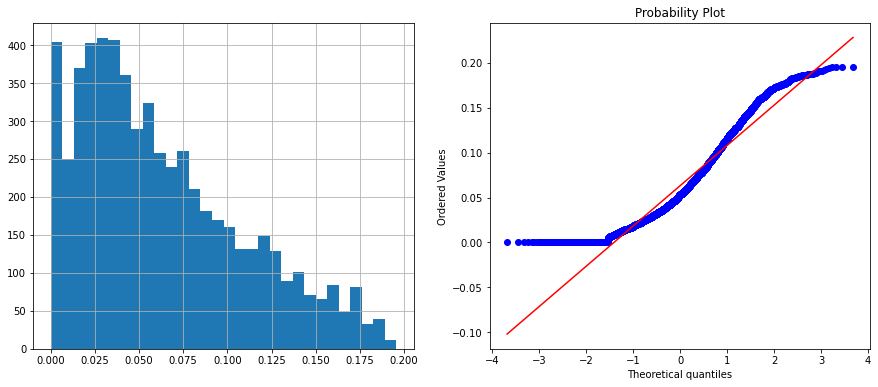

Graph of Item_MRP


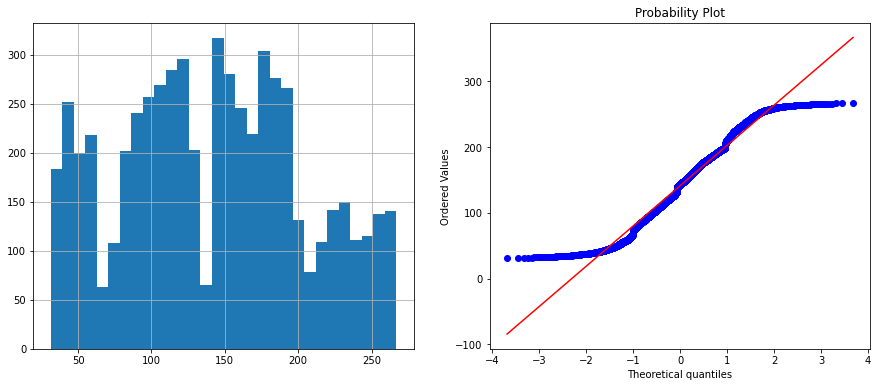

Graph of Item_Weight


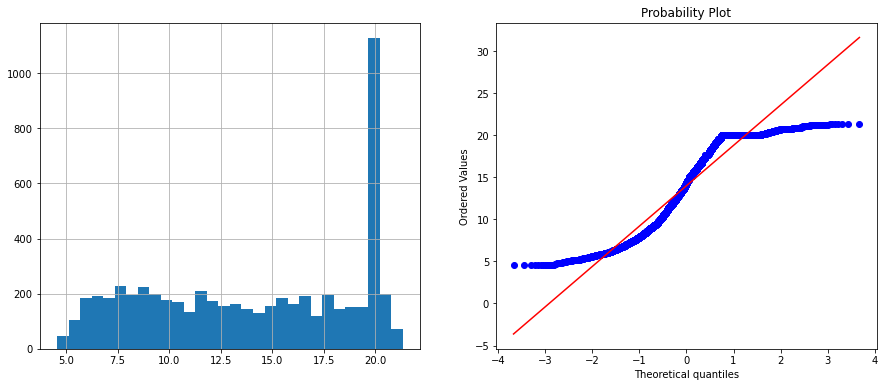

In [31]:
def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    print(f'Graph of {variable}')
    plt.show()
diagnostic_plots(X_train_enc, 'Item_Visibility')
diagnostic_plots(X_train_enc, 'Item_MRP')
diagnostic_plots(X_train_enc, 'Item_Weight')

Graphs of encoded X train after Yeo-Johnson Transformer

Graph of X train after Yeo Johnson Transformer
Graph of Item_Visibility


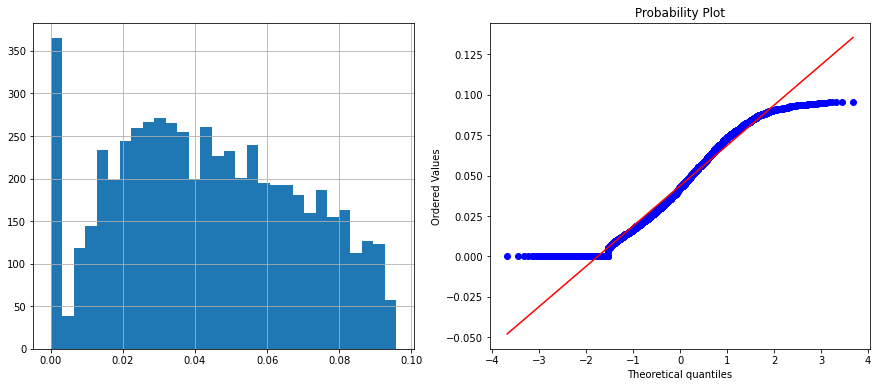

Graph of Item_MRP


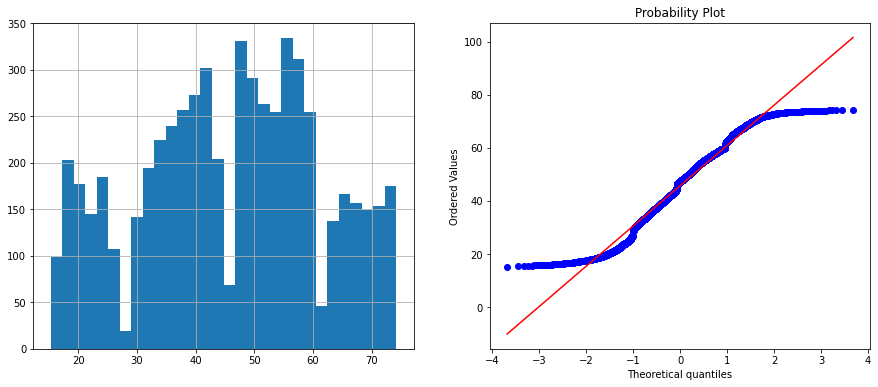

Graph of Item_Weight


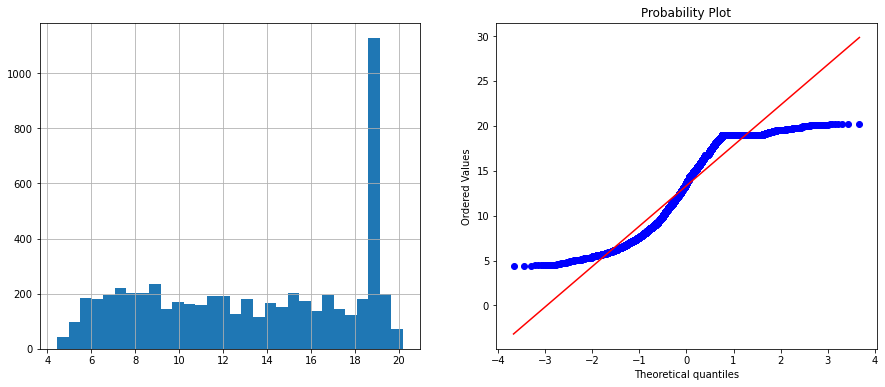

In [32]:
yjt = YeoJohnsonTransformer(variables = ['Item_Visibility','Item_MRP','Item_Weight'])
yjt.fit(X_train_enc)
data_tf = yjt.transform(X_train_enc)

print("Graph of X train after Yeo Johnson Transformer")
diagnostic_plots(data_tf, 'Item_Visibility')
diagnostic_plots(data_tf, 'Item_MRP')
diagnostic_plots(data_tf, 'Item_Weight')

Repeat this transformation process for X test , we will get similar results with the values being more transformed into a more normal distribution.

Graph of X test after Yeo Johnson Transformer
Graph of Item_Visibility


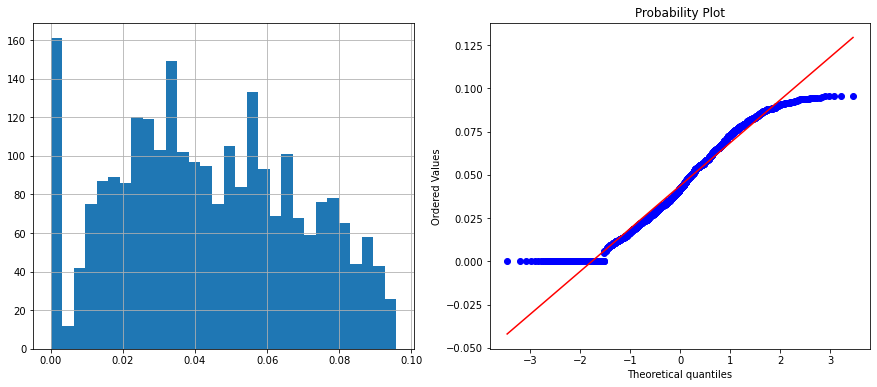

Graph of Item_MRP


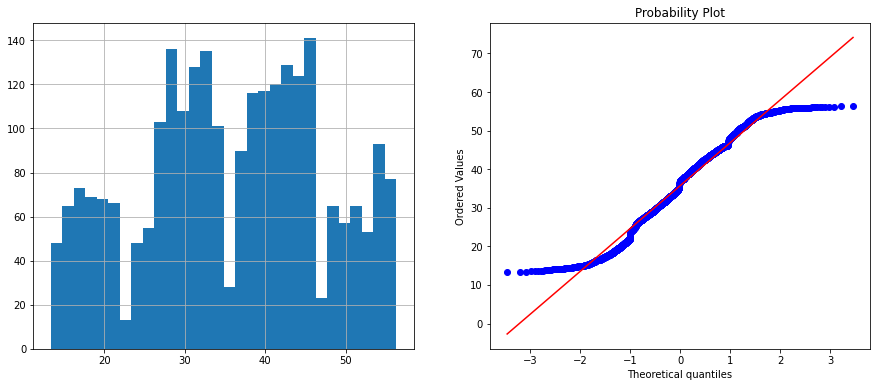

Graph of Item_Weight


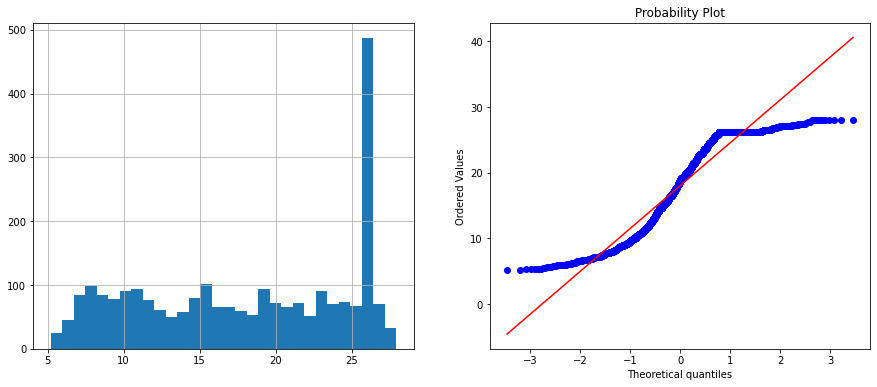

In [33]:
yjt.fit(X_test_enc)

data_tf_test = yjt.transform(X_test_enc)
print("Graph of X test after Yeo Johnson Transformer")
diagnostic_plots(data_tf_test, 'Item_Visibility')
diagnostic_plots(data_tf_test, 'Item_MRP')
diagnostic_plots(data_tf_test, 'Item_Weight')


From the transformation of numerical variables, we are able to achieve a more normal looking distribution, as we can see from the histogram and probabililty plots. This will assist in our machine learning linear regression model be more efficient. 

### Step 6.1.1: Comparing Yeo-Johnson Transformation with Power Transformation on Numerical Variables 

For comparison's sake, lets also explore the Power transformation on the numerical variables. 
As we can see below, for Item MRP and Item Weight, we managed to achieve a more normal distribution like with the Yeo-Johnson transformer. However it is not as effective on Item Visibility as this column contains a high number of 0 values who do not work well with exponential or logarithmic transformations. I decided on Yeo-Johnson because it is able to handle both 0 values and negative values in case the previous transformations led to the numerical data being negative; it worked effectively on X train and X test to make the data follow a more normal distribution.

Therefore we will proceed with the next steps with using our transformed data from the Yeo-Johnson transformer.

Graph of X test after Power Transformer
Graph of Item_Visibility


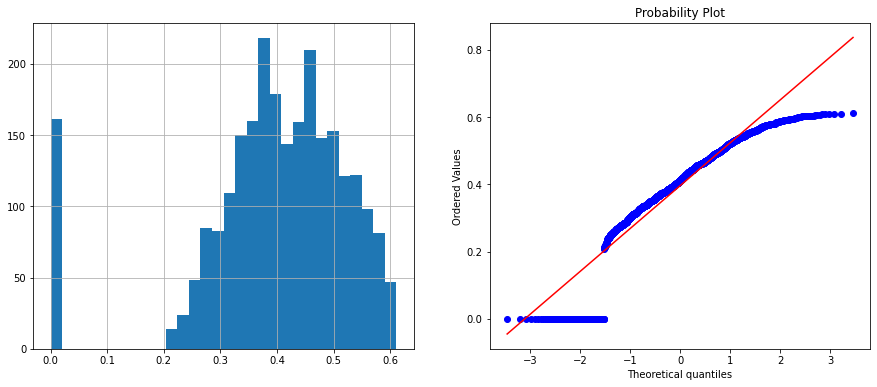

Graph of Item_MRP


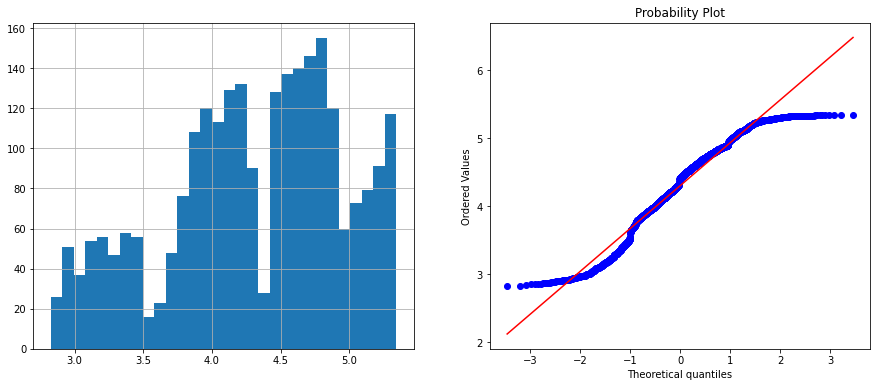

Graph of Item_Weight


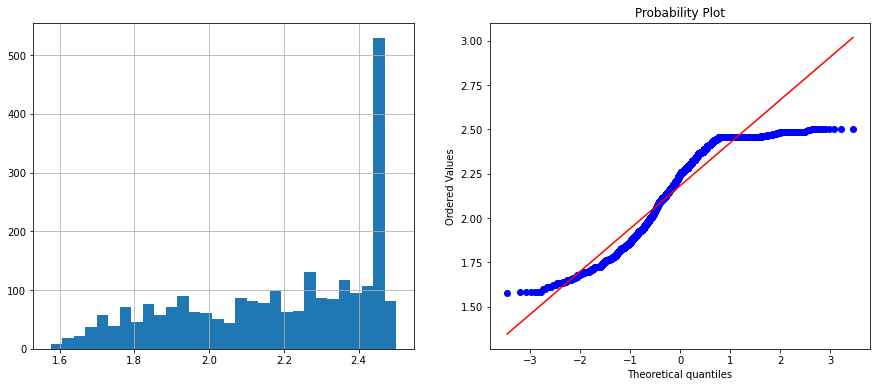

In [34]:
et = PowerTransformer(variables = ['Item_Weight', 'Item_MRP', 'Item_Visibility'], exp=0.3)

# fit transformer to data
et.fit(X_test_enc)

data_tf_power = et.transform(X_test_enc)

print("Graph of X test after Power Transformer")
diagnostic_plots(data_tf_power, 'Item_Visibility')
diagnostic_plots(data_tf_power, 'Item_MRP')
diagnostic_plots(data_tf_power, 'Item_Weight')

### Step 6.2: Exploring Variable Discretization/Binning

 
Next we will explore binning the data as it may assist to visualize if it has a linear relationship with the target variable. The binning process will help to general intervals of different frequency.

I have chosen the numerical variables Item_Visibility and Item_MRP as these two variables are likely to have an impact on the Item_Outlet_Sales. Earlier we trimmed the data for Item Visibility as it contains outliers, so binning the data would further improve the distribution of skewed variables and minimize the influence of any outlier data.

For Item_MRP, there is a large range of data, there

We will explore from the results below whether there is a linear relationship with the target variable.

In [35]:
disc = EqualFrequencyDiscretiser(
    q=10, variables=['Item_Visibility', 'Item_MRP'], return_object=True)

disc.fit(data_tf)

# generate intervals with equal frequency. then do a fit.

EqualFrequencyDiscretiser(return_object=True,
                          variables=['Item_Visibility', 'Item_MRP'])

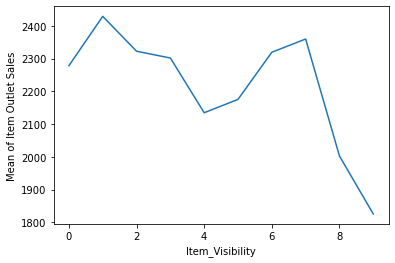

In [36]:
# Task 2: Explore if the bins have a linear relationship with the target

train_t = disc.transform(data_tf)
test_t = disc.transform(data_tf_test)
pd.concat([train_t, y_train], axis=1).groupby('Item_Visibility')['Item_Outlet_Sales'].mean().plot()
plt.ylabel('Mean of Item Outlet Sales')
plt.show()

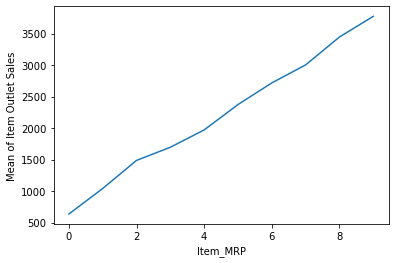

In [37]:
pd.concat([train_t, y_train], axis=1).groupby('Item_MRP')['Item_Outlet_Sales'].mean().plot()
plt.ylabel('Mean of Item Outlet Sales')
plt.show()

From the results above from discretization, Item_MRP seems to have a positive correlation with the mean of the target variable Sales. While Item Visibility does not appear to a linear relationship with Item Outlet Sales.

However, it is decided to not bin the data as the above findings do not provide much additional value into organizing the dataset.Therefore we will proceed with transformation and scaling with the data_tf variable from the previous section.

From the data correlation table below, we can see that there is a relatively positive correlation between the 2 variables, at least relative to the other variables. This may be because products with a higher retail price overall generate more sales and bring a higher revenue to the company. However we do not have the cost that the company has to bear to procure the products so we are unable to determine which products overall bring in more profit due to the limitations in the dataset.

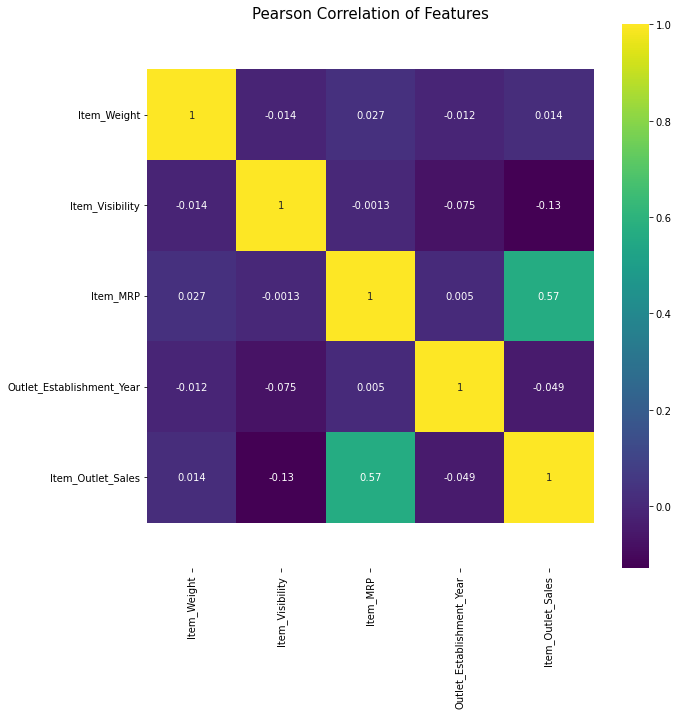

In [38]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=15)
ax = sns.heatmap(data.corr(), cmap=colormap, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()


### Step 7: Feature Engineer
### Step 7.1: MinMax Scaling

Our model will perform better when numerical variables are scaled to a standard range.Therefore we will attempt to do MinMax scaling for our model.We will do this for both X train and X test.
Slightly better results were yielded from MinMax scaling, therefore we will be using the MinMax scaler in our multiple regression model. This type of scaling transforms with feature into a given range.

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(data_tf)

# transform train and test sets
X_train_scaled = scaler.transform(data_tf)
X_test_scaled = scaler.transform(data_tf_test)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=data_tf.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=data_tf_test.columns)

As we can see from the minmax scaler below,, the values are now scaled to a more normal looking distribution. Even though it is not ideal, it is far better than what we had before.

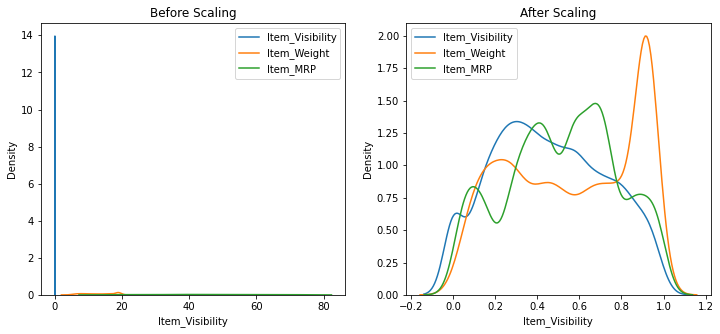

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(data_tf['Item_Visibility'], ax=ax1, label ='Item_Visibility')
sns.kdeplot(data_tf['Item_Weight'], ax=ax1, label ='Item_Weight')
sns.kdeplot(data_tf['Item_MRP'], ax=ax1, label ='Item_MRP')

ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled['Item_Visibility'], ax=ax2, label ='Item_Visibility')
sns.kdeplot(X_train_scaled['Item_Weight'], ax=ax2, label ='Item_Weight')
sns.kdeplot(X_train_scaled['Item_MRP'], ax=ax2, label ='Item_MRP')
 
ax2.legend()
plt.show()

We will repeat the same thing for X test. From the graph below, the values are also scaled to a more normal looking distribution compared to before. However, just from a visual comparison, X train seems to have a more normal scaling output than X test. X test also seems to cover a bigger range than X train, it might be due to the values within X test.

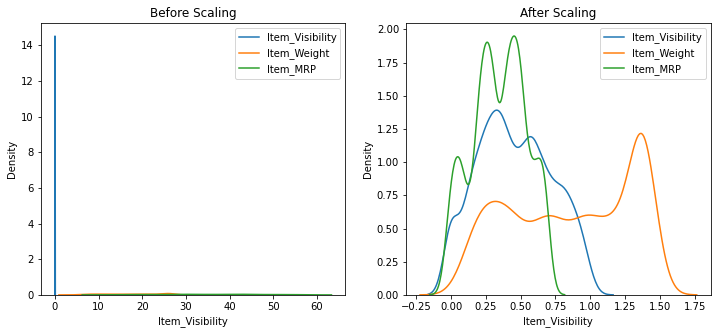

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(data_tf_test['Item_Visibility'], ax=ax1, label ='Item_Visibility')
sns.kdeplot(data_tf_test['Item_Weight'], ax=ax1, label ='Item_Weight')
sns.kdeplot(data_tf_test['Item_MRP'], ax=ax1, label ='Item_MRP')


ax1.legend()

# after scaling
ax2.set_title('After Scaling')

sns.kdeplot(X_test_scaled['Item_Visibility'], ax=ax2, label ='Item_Visibility')
sns.kdeplot(X_test_scaled['Item_Weight'], ax=ax2, label ='Item_Weight')
sns.kdeplot(X_test_scaled['Item_MRP'], ax=ax2, label ='Item_MRP')

ax2.legend()
plt.show()

As we can see above, the data is scaled and follows a more normal distribution compared to before scaling. However, as there are several variables in play, we may want to remove statistically insignificant or unimportant features from our dataset so as not to complicate our machine learning model further.

We will also apply this to x test.

We will also compare the results of X train (MinMax scaler) with standard scaler as illustrated below.

### Step 7.2: Standard Scaling

In [42]:
scaler2 = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler2.fit(data_tf)

# transform train and test sets
X_train_scaled2 = scaler2.transform(data_tf)
X_test_scaled2 = scaler2.transform(data_tf_test)


X_train_scaled2 = pd.DataFrame(X_train_scaled2, columns=data_tf.columns)
X_test_scaled2 = pd.DataFrame(X_test_scaled2, columns=data_tf_test.columns)

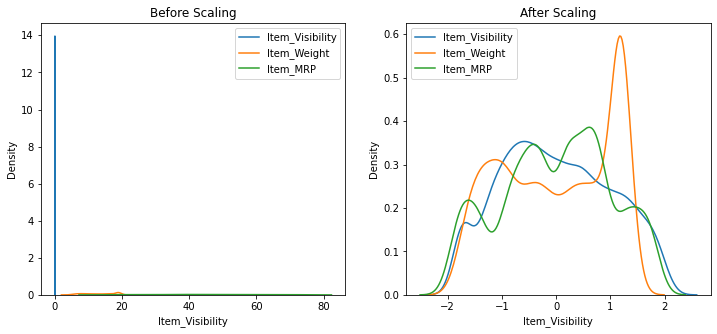

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(data_tf['Item_Visibility'], ax=ax1, label ='Item_Visibility')
sns.kdeplot(data_tf['Item_Weight'], ax=ax1, label ='Item_Weight')
sns.kdeplot(data_tf['Item_MRP'], ax=ax1, label ='Item_MRP')

ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train_scaled2['Item_Visibility'], ax=ax2, label ='Item_Visibility')
sns.kdeplot(X_train_scaled2['Item_Weight'], ax=ax2, label ='Item_Weight')
sns.kdeplot(X_train_scaled2['Item_MRP'], ax=ax2, label ='Item_MRP')
 
ax2.legend()
plt.show()

MinMax scaler seems to be slightly more effective than Standard scaler in terms of r2 score, therefore we will stick to MinMax scaler. However both scalers are effective at achieving a more normal distribution with the data. It still does not follow a normal distribution closely but is greatly improved.Due to the arbitrary number imputation, we still see that the Item Weight distribution is skewed due to the large number of missing values while item MRP and item visibility follow a more normal distribution. We may consider removing the Item Weight column to improve our model in further steps if necessary.

### Step 8: Multiple Linear Regression Modelling

We will firstly visualize the X train scaled table so I can get an idea of how the data looks like and whether all columns appear to be properly scaled by the MinMax scaler. We will then fit this into the LinearRegression model and evaluate the model based on MAE and r2 score before considering possible improvements.

The coefficients of X train will also be printed so I can determine which columns are statistically insignificant to the model and can be removed without affecting the r2 and MAE negatively.

In [44]:
X_train_scaled

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier_OUT027,...,Item_Type_Fruits and Vegetables,Item_Type_Breakfast,Item_Type_Meat,Item_Type_Frozen Foods,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Hard Drinks,Item_Type_Breads,Item_Type_Others,Item_Type_Seafood
0,0.124594,0.920633,1.0,0.785763,0.159952,0.000000,1.000000,0.5,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.207657,0.378799,0.0,0.918508,0.384901,0.083333,0.666667,0.5,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.480857,0.286138,0.0,0.647701,0.544693,0.500000,0.333333,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.220636,0.950043,0.0,0.858128,0.309184,0.500000,0.333333,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.346528,0.345956,1.0,0.179176,0.300470,0.541667,0.000000,0.5,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860,0.345230,0.104538,0.0,0.256324,0.289480,0.083333,0.666667,0.5,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5861,0.900714,0.595871,0.0,0.499697,0.581548,0.500000,0.333333,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5862,0.035691,0.483056,0.0,0.228495,0.022820,0.916667,0.000000,1.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5863,0.404932,0.920633,0.0,0.000000,0.357013,0.000000,1.000000,0.5,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
regressor_multi = LinearRegression()
model = regressor_multi.fit(X_train_scaled, y_train)

# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
# The lower MAE, the better model performance
print('train_mae:', mean_absolute_error(regressor_multi.predict(X_train_scaled), y_train))

train_mae: 779.1538625063938


In [46]:
print('r2 for X_train:',regressor_multi.score(X_train_scaled, y_train))

r2 for X_train: 0.6252890021079294


In [47]:
print(regressor_multi.coef_) # Check the coefficients

[ 3.13482618e+03 -4.37020516e+01 -6.03724398e+00 -1.78048680e+02
  8.49394606e+02  8.37126321e+15  9.58232637e+15  2.89262312e+15
 -5.14446689e+15  1.36938947e+15  2.15107069e+15  3.30346470e+15
  1.27281471e+15 -2.03077685e+15  1.16924038e+14  1.86093721e+15
 -1.04315183e+16 -3.78235815e+15  4.05945172e+15  2.93039024e+12
  2.93039024e+12  2.93039024e+12  2.93039024e+12  2.93039024e+12
  2.93039024e+12  2.93039024e+12  2.93039024e+12  2.93039024e+12
  2.93039024e+12  2.93039024e+12  2.93039024e+12  2.93039024e+12
  2.93039024e+12  2.93039024e+12  2.93039024e+12]


Next, we will display the column names and coefficients so as to have a visual representation of which variables to possibly cull. Values (positive or negative) that are closer to 0 would have a smaller impact on the linear model and should be removed to improve the accuracy of the model and make it less complicated. We will try removing as many statistically insignificant columns without compromising on the r2 or MAE for the linear model.

In [48]:
# displays column name and coefficient
names = X_train_scaled.columns
list(zip(names,regressor_multi.coef_))

[('Item_Identifier', 3134.826181884884),
 ('Item_Weight', -43.70205160352271),
 ('Item_Fat_Content', -6.0372439801299365),
 ('Item_Visibility', -178.04868035466538),
 ('Item_MRP', 849.3946063126933),
 ('Outlet_Establishment_Year', 8371263211687285.0),
 ('Outlet_Size', 9582326369791802.0),
 ('Outlet_Location_Type', 2892623116366227.0),
 ('Outlet_Type', -5144466885423183.0),
 ('Outlet_Identifier_OUT027', 1369389465380730.5),
 ('Outlet_Identifier_OUT013', 2151070692528415.5),
 ('Outlet_Identifier_OUT046', 3303464702439007.0),
 ('Outlet_Identifier_OUT010', 1272814710082413.2),
 ('Outlet_Identifier_OUT035', -2030776850669281.0),
 ('Outlet_Identifier_OUT017', 116924037800397.9),
 ('Outlet_Identifier_OUT045', 1860937206901866.0),
 ('Outlet_Identifier_OUT018', -1.0431518336590254e+16),
 ('Outlet_Identifier_OUT049', -3782358145062714.0),
 ('Outlet_Identifier_OUT019', 4059451717998993.0),
 ('Item_Type_Baking Goods', 2930390240038.547),
 ('Item_Type_Snack Foods', 2930390240064.7954),
 ('Item_Type

In [49]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  5865 non-null   float64
 1   Item_Weight                      5865 non-null   float64
 2   Item_Fat_Content                 5865 non-null   float64
 3   Item_Visibility                  5865 non-null   float64
 4   Item_MRP                         5865 non-null   float64
 5   Outlet_Establishment_Year        5865 non-null   float64
 6   Outlet_Size                      5865 non-null   float64
 7   Outlet_Location_Type             5865 non-null   float64
 8   Outlet_Type                      5865 non-null   float64
 9   Outlet_Identifier_OUT027         5865 non-null   float64
 10  Outlet_Identifier_OUT013         5865 non-null   float64
 11  Outlet_Identifier_OUT046         5865 non-null   float64
 12  Outlet_Identifier_OU

In [50]:
regressor_multi.fit(X_test_scaled, y_test)
print('test_mae:',mean_absolute_error(regressor_multi.predict(X_test_scaled), y_test))

test_mae: 668.6268059665872


In [51]:
print('r2 for X_test:',regressor_multi.score(X_test_scaled, y_test))

r2 for X_test: 0.692416290136832


### Step 8.1: Evaluation of Model & Possible Improvements

Currently the r2 score and train MAE is not ideal.This may be due to the multiple variables involved in the regression model, as more variables may affect the data and make it less accurate. To improve the model, I tried with standard scalar, got a higher MAE but values still about the same.I also attempted to remove columns that seemed to be less relevant , based on domain knowledge about supermarkets ( Outlet Year, etc.), with minimal or negative impact to the r2 score.

As the data question is to predict the sales of each product and each outlet, I am unable to drop Item and Outlet Identifier. This proves to be challenging because Item Identifier has many many categories which do now follow a specific order. This makes it difficult to encode with either one hot encoding ( too many columns) or ordinal encoding ( the values do not follow any order). I attempted to do so with both types of encoding, with one hot encoding yielding slightly better r2 results but leading to a sparse matrix with too many variables correlated and too much memory consumption.

<b> For our next step, we will drop the following columns that are statistically insignificant/ not important. </b>

Item Weight - Low coefficient score. There are a lot of  missing values from Item_Weight due to missing values from two particular outlets (not random). I have input in an arbitrary number of 20 using arbitrary imputation to indicate that the missing values are not random, however this would affect the distribution of values.I could also drop rows with missing values for Weight, but the downside of dropping the rows for these 2 outlets with missing values, is that these 2 outlets would not be included in the linear regression model and may not be appropriate as the data question was to predict sales of each product for each outlet.

Item Fat Content - Low coefficient score close to 0 relative to other variables, therefore may not be significant to the model.

We will disregard the columns transformed by One Hot Encoder for now, as it causes a variable to have more coefficients.

We will drop columns that are not statistically significant as illustrated above by the coefficients, then we check the r2 again.

The MAE and r2 is still not ideal, but we have managed to reduce the number of variables in the ML model and determine which variables are not important.This may be useful to the supermarket team as it helps to determine which information is more important to predicting Outlet Sales. They can then focus their budget on the more important variables to improve sales.

In [52]:
X_train_drop = X_train_scaled.drop(columns=['Item_Fat_Content','Item_Weight'])
X_test_drop = X_test_scaled.drop(columns=['Item_Fat_Content','Item_Weight'])

In [53]:
model = regressor_multi.fit(X_train_drop, y_train)

# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
print('X train drop_mae:', mean_absolute_error(regressor_multi.predict(X_train_drop), y_train))

X train drop_mae: 779.0643389599319


In [54]:
print('r2 for X_train drop :',regressor_multi.score(X_train_drop, y_train))

r2 for X_train drop : 0.6252469198201507


We will do the same dropping of columns for X test since it was successful for X train. We can see that the train and r2 score remain the same after dropping the four columns.

In [55]:
model = regressor_multi.fit(X_test_drop, y_test)

print('X test drop_mae:', mean_absolute_error(regressor_multi.predict(X_test_drop), y_test))
print('r2 for X_test_drop:',regressor_multi.score(X_test_drop, y_test))

X test drop_mae: 667.721731662689
r2 for X_test_drop: 0.6924497252359636


I also attemped to drop even more columns, limiting to the 6th column onwards. However, This seems to affect the linear model negatively as the MAE increases and the r2 decreases. It seems like it is ok to drop statistically insignificant columns, but not to take too aggressive an approach in dropping data as other columns can also affect the linear model significantly.

Based on the Coefficients, Item_Type categories seem to have a similar coefficient for each category. Therefore we will continue to drop the columns for Item Type to below to see if the model is affected. First we will display the information to see which column number should we cut off at.

In [56]:
X_train_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  5865 non-null   float64
 1   Item_Visibility                  5865 non-null   float64
 2   Item_MRP                         5865 non-null   float64
 3   Outlet_Establishment_Year        5865 non-null   float64
 4   Outlet_Size                      5865 non-null   float64
 5   Outlet_Location_Type             5865 non-null   float64
 6   Outlet_Type                      5865 non-null   float64
 7   Outlet_Identifier_OUT027         5865 non-null   float64
 8   Outlet_Identifier_OUT013         5865 non-null   float64
 9   Outlet_Identifier_OUT046         5865 non-null   float64
 10  Outlet_Identifier_OUT010         5865 non-null   float64
 11  Outlet_Identifier_OUT035         5865 non-null   float64
 12  Outlet_Identifier_OU

In [57]:
X_train_drop2 = X_train_drop.iloc[:, 0:15]

In [58]:
model = regressor_multi.fit(X_train_drop2, y_train)

# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
# The lower MAE, the better model performance
print('train_mae:', mean_absolute_error(regressor_multi.predict(X_train_drop2), y_train))
print('r2 for X_train drop2 :',regressor_multi.score(X_train_drop2, y_train))

train_mae: 778.8853912305989
r2 for X_train drop2 : 0.6248615222674787


From the results above after dropping Item_Type, the model does not seem to have much of a change in MAE or r2 score. This could be due to other factors such as Outlet Identifier and Item Identifier having more of an impact on the MAE or r2.
After dropping Item_Type, we arrive at the X_train_drop2 model containing the following variables as illustrated below. We will repeat the same for x test, the values are roughly the same for the r2 and MAE even after dropping the columns.

In [59]:
X_train_drop2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5865 non-null   float64
 1   Item_Visibility            5865 non-null   float64
 2   Item_MRP                   5865 non-null   float64
 3   Outlet_Establishment_Year  5865 non-null   float64
 4   Outlet_Size                5865 non-null   float64
 5   Outlet_Location_Type       5865 non-null   float64
 6   Outlet_Type                5865 non-null   float64
 7   Outlet_Identifier_OUT027   5865 non-null   float64
 8   Outlet_Identifier_OUT013   5865 non-null   float64
 9   Outlet_Identifier_OUT046   5865 non-null   float64
 10  Outlet_Identifier_OUT010   5865 non-null   float64
 11  Outlet_Identifier_OUT035   5865 non-null   float64
 12  Outlet_Identifier_OUT017   5865 non-null   float64
 13  Outlet_Identifier_OUT045   5865 non-null   float

In [60]:
X_test_drop2 = X_test_drop.iloc[:, 0:15]
model = regressor_multi.fit(X_test_drop2, y_test)

# Evaluate the Linear Regression Model using Mean Absolute Error (MAE)
# The lower MAE, the better model performance
print('X test drop2_mae:', mean_absolute_error(regressor_multi.predict(X_test_drop2), y_test))
print('r2 for X_test drop2 :',regressor_multi.score(X_test_drop2, y_test))

X test drop2_mae: 668.174070336226
r2 for X_test drop2 : 0.691165654981323


Even though I did not manage to change the r2 values much by dropping columns, it can still help the marketing team as they know which variables to focus on to improve sales. X_train_drop2 is much simpler than X train scaled originally after I have dropped the statistically insignificant columns. It also saves time on data collection by prioritizing the most important variables in the model. If data collection time is an issue, having less variables would require less work on the part of the data entry staff, especially if new items and new outlets are added to the original data.